# 0. 트랜스포머를 이용해 멋진 챗봇 만들기

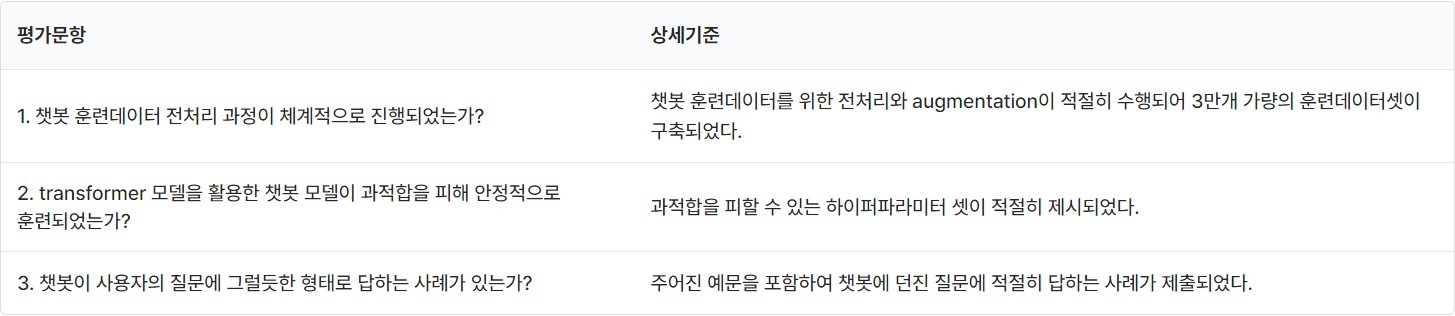

In [1]:
import re
import os
import random
import math

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from konlpy.tag import Mecab
!pip install gensim==3.8.0
from gensim.models import Word2Vec

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [2]:
tf.random.set_seed(9)
np.random.seed(9)
random.seed(9)

# 1. 데이터 다운로드

준비하기 단계에서 심볼릭 링크를 생성했다면 아래 파일이 ChatbotData .csv라는 이름으로 저장되어 있을거예요. csv 파일을 읽는 데에는 pandas 라이브러리가 적합합니다. 읽어 온 데이터의 질문과 답변을 각각 questions, answers 변수에 나눠서 저장하세요!

https://github.com/songys/Chatbot_data

In [3]:
file_path = "data/ChatbotData.csv"

que_ans_sentences = pd.read_csv(file_path)[['Q', 'A']]
que_ans_sentences

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.
...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.


# 2. 데이터 정제

아래 조건을 만족하는 preprocess_sentence() 함수를 구현하세요.

1. 영문자의 경우, 모두 소문자로 변환합니다.  
2. 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거합니다.

문장부호 양옆에 공백을 추가하는 등 이전과 다르게 생략된 기능들은 우리가 사용할 토크나이저가 지원하기 때문에 굳이 구현하지 않아도 괜찮습니다!

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'\([^)]*\)', r'', sentence)
    sentence = re.sub(r"[^a-zㄱ-ㅣ가-힣0-9?.!,~]+", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r'(.)\1+', r'\1' * 2, sentence)
    sentence = sentence.strip()
    return sentence


In [5]:
preprocess_sentence('  ㅋ(ㅋㅋㅋ)ㅋㅋ@ㅋAㅋ키키키키키ㅋㅋㅋㅣㅣ   ㅣㅣㅣ  ')

'ㅋㅋ ㅋaㅋ키키ㅋㅋㅣㅣ ㅣㅣ'

# 3. 데이터 토큰화

토큰화에는 KoNLPy의 mecab 클래스를 사용합니다.

아래 조건을 만족하는 build_corpus() 함수를 구현하세요!

1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.  
2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.
3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
5. 중복되는 문장은 데이터에서 제외합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!

구현한 함수를 활용하여 questions 와 answers 를 각각 que_corpus , ans_corpus 에 토큰화하여 저장합니다.

In [6]:
def tokenize_corpus(que_ans_sentences, mecab):
    que_ans_corpus = []
    
    for que, ans in que_ans_sentences.iloc:
        que_sentence = ' '.join(mecab.morphs(preprocess_sentence(que)))
        ans_sentence = ' '.join(mecab.morphs(preprocess_sentence(ans)))
        que_ans_corpus.append([que_sentence, ans_sentence])
    
    que_ans_corpus = pd.DataFrame(que_ans_corpus, columns=['Q', 'A'])
    
    return que_ans_corpus

In [7]:
mecab = Mecab()

que_ans_corpus = tokenize_corpus(que_ans_sentences, mecab)
que_ans_corpus

,Q,A
0,12 시 땡 !,하루 가 또 가 네요 .
1,1 지망 학교 떨어졌 어,위로 해 드립니다 .
2,3 박 4 일 놀 러 가 고 싶 다,여행 은 언제나 좋 죠 .
3,3 박 4 일 정도 놀 러 가 고 싶 다,여행 은 언제나 좋 죠 .
4,ppl 심하 네,눈살 이 찌푸려 지 죠 .
...,...,...
11818,훔쳐 보 는 것 도 눈치 보임 .,티 가 나 니까 눈치 가 보이 는 거 죠 !
11819,훔쳐 보 는 것 도 눈치 보임 .,훔쳐 보 는 거 티나 나 봐요 .
11820,흑기사 해 주 는 짝 남 .,설렜 겠 어요 .
11821,힘든 연애 좋 은 연애 라는 게 무슨 차이 일까 ?,잘 헤어질 수 있 는 사이 여부 인 거 같 아요 .


In [8]:
def cal_sentence_length(raw):
    sen_lens = [len(sen.split()) for sen in raw]

    print("문장의 최단 길이:", min(sen_lens))
    print("문장의 최장 길이:", MAX_LEN := max(sen_lens))
    print("문장의 최빈 길이:", np.argmax(np.bincount(sen_lens)))

    len_counts = np.zeros(MAX_LEN+1, dtype=np.int)

    for i in range(1, MAX_LEN+1):
        len_counts[i] += sen_lens.count(i)

    plt.bar(range(MAX_LEN+1), len_counts, width=1.0)
    plt.title("Sentence Length Distribution")
    plt.show()

문장의 최단 길이: 1
문장의 최장 길이: 32
문장의 최빈 길이: 5


/tmp/ipykernel_4187/2611661610.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  len_counts = np.zeros(MAX_LEN+1, dtype=np.int)


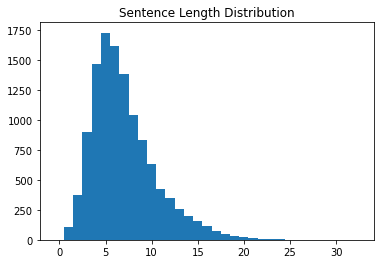

In [9]:
cal_sentence_length(que_ans_corpus['Q'])

문장의 최단 길이: 1
문장의 최장 길이: 40
문장의 최빈 길이: 7


/tmp/ipykernel_4187/2611661610.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  len_counts = np.zeros(MAX_LEN+1, dtype=np.int)


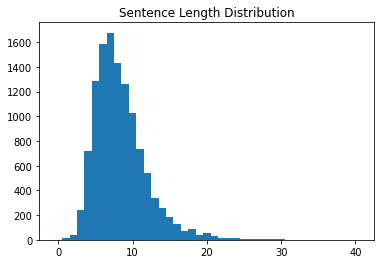

In [10]:
cal_sentence_length(que_ans_corpus['A'])

In [11]:
def build_corpus(que_ans_corpus, MIN_LEN, MAX_LEN):
    que_ans_corpus = que_ans_corpus[que_ans_corpus.apply(
        lambda x: (MIN_LEN <= len(x[0].split()) <= MAX_LEN)
        and (MIN_LEN <= len(x[1].split()) <= MAX_LEN-2), axis=1)]
    
    que_ans_corpus.drop_duplicates(subset = ['Q'], inplace=True)
    que_ans_corpus.drop_duplicates(subset = ['A'], inplace=True)

    return que_ans_corpus

In [12]:
MIN_LEN = 2
MAX_LEN = 18

que_ans_corpus = build_corpus(que_ans_corpus, MIN_LEN, MAX_LEN)
len(que_ans_corpus)

/opt/conda/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


7306

In [13]:
que_ans_corpus

,Q,A
0,12 시 땡 !,하루 가 또 가 네요 .
1,1 지망 학교 떨어졌 어,위로 해 드립니다 .
2,3 박 4 일 놀 러 가 고 싶 다,여행 은 언제나 좋 죠 .
4,ppl 심하 네,눈살 이 찌푸려 지 죠 .
5,sd 카드 망가졌 어,다시 새로 사 는 게 마음 편해요 .
...,...,...
11814,회사 에서 어떤 사람 이랑 자꾸 눈 마추 쳐 .,눈 마주치 는 게 우연 인지 잘 살펴 보 세요 .
11817,후회 없이 사랑 하 고 싶 어,진심 으로 다가가 보 세요 .
11818,훔쳐 보 는 것 도 눈치 보임 .,티 가 나 니까 눈치 가 보이 는 거 죠 !
11820,흑기사 해 주 는 짝 남 .,설렜 겠 어요 .


In [14]:
indices = np.arange(len(que_ans_corpus))
np.random.shuffle(indices)
que_ans_corpus = que_ans_corpus.iloc[indices]
que_ans_corpus

,Q,A
5000,학원 폭력 짜증 나,학교 폭력 은 범죄 에 요 .
2127,봄 방학 이 다 !,부럽 네요 .
9055,그 사람 이 뭐 하 는지 궁금 해 .,뭐 하 냐고 물어봐 봐요 .
3861,입 안 이 다 헐 었 어,요즘 피곤 하 신가 봐요 .
10567,여자 친구 가 게임 을 너무 하 는 게 고민 이 야 .,피시방 데이트 해 보 세요 .
...,...,...
10289,썸남 의 계속 되 는 약속 취소 .,괘씸 하 니 약속 잡 고 취소 한번 하 세요 .
751,남자 친구 랑 종교 문제 로 다툼,종교 의 자유 를 인정 해 주 세요 .
11113,좋 아 하 는 사람 의 심리 를 모르 겠 어 .,충분 한 대화 를 나눠 보 는 게 필요 해요 .
7942,저 잘 잊 을 수 있 겠 죠 ?,아무렇 지 도 않 게 추억 할 날 이 올 거 예요 .


In [15]:
test_sentence_count = 10

In [16]:
train_que_ans_corpus = que_ans_corpus[: -test_sentence_count]
test_que_ans_corpus = que_ans_corpus[-test_sentence_count: ]

In [17]:
print("Train Example:", len(train_que_ans_corpus))
train_que_ans_corpus

Train Example: 7296


,Q,A
5000,학원 폭력 짜증 나,학교 폭력 은 범죄 에 요 .
2127,봄 방학 이 다 !,부럽 네요 .
9055,그 사람 이 뭐 하 는지 궁금 해 .,뭐 하 냐고 물어봐 봐요 .
3861,입 안 이 다 헐 었 어,요즘 피곤 하 신가 봐요 .
10567,여자 친구 가 게임 을 너무 하 는 게 고민 이 야 .,피시방 데이트 해 보 세요 .
...,...,...
5164,혼자 만 의 시간 을 갖 고 싶 어,지쳤 나 봐요 .
7159,오늘 도 술 몇 잔 마시 니 생각나 네요 .,술 한잔 에 그리움 이 사무치 네요 .
9296,남자 친구 가 sns 에 나 안 올려 .,개인 성향 차이 인 것 같 아요 .
11032,좋 아 하 는 거 기준 이 뭐 임 ?,계속 생각나 고 보 고 싶 은 게 기본 이 겠 지요 .


In [18]:
print("Test Example:", len(test_que_ans_corpus))
test_que_ans_corpus

Test Example: 10


,Q,A
9588,다시 만나 서 사랑 할 수 있 을까 ?,진정 으로 사랑 한다면 다시 시작 해 보 세요 .
8260,찌질 한 이별 중,얼른 정리 하 세요 .
2026,버려야 되 는데 . .,잘 버리 는 것 도 중요 해요 .
8769,환승 이 별 3 달째 를 앞둬 도 힘들 다,점점 더 괜찮 아 질 거 예요 .
3594,웹툰 뭐 볼까,안 본 웹툰 이 있 는지 먼저 물 어 보 고 싶 네요 .
10289,썸남 의 계속 되 는 약속 취소 .,괘씸 하 니 약속 잡 고 취소 한번 하 세요 .
751,남자 친구 랑 종교 문제 로 다툼,종교 의 자유 를 인정 해 주 세요 .
11113,좋 아 하 는 사람 의 심리 를 모르 겠 어 .,충분 한 대화 를 나눠 보 는 게 필요 해요 .
7942,저 잘 잊 을 수 있 겠 죠 ?,아무렇 지 도 않 게 추억 할 날 이 올 거 예요 .
572,나 함부로 말 하 는 거 고치 고 싶 어,고치 고 싶 다는 마음 에서 시작 하 세요 .


#  4. Augmentation

우리에게 주어진 데이터는 1만 개가량으로 적은 편에 속합니다. 이럴 때에 사용할 수 있는 테크닉을 배웠으니 활용해 봐야겠죠? Lexical Substitution을 실제로 적용해 보도록 하겠습니다.

아래 링크를 참고하여 한국어로 사전 훈련된 Embedding 모델을 다운로드합니다. Korean (w) 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로 사이트에서 Korean (w)를 찾아 다운로드하고, ko.bin 파일을 얻으세요!

https://github.com/Kyubyong/wordvectors

다운로드한 모델을 활용해 데이터를 Augmentation 하세요! 앞서 정의한 lexical_sub() 함수를 참고하면 도움이 많이 될 겁니다.

Augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록, 이후엔 반대로 원본 que_corpus 와 Augmentation된 ans_corpus 가 병렬을 이루도록 하여 전체 데이터가 원래의 3배가량으로 늘어나도록 합니다.

In [19]:
wv_path = 'data/ko.bin'
word2vec = Word2Vec.load(wv_path)

In [20]:
word2vec.most_similar("바나나")

/tmp/ipykernel_4187/368481777.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  word2vec.most_similar("바나나")


[('코코넛', 0.8097119927406311),
 ('시금치', 0.7701147794723511),
 ('레몬', 0.76884925365448),
 ('땅콩', 0.7684735059738159),
 ('파인애플', 0.7639915347099304),
 ('녹차', 0.7631460428237915),
 ('딸기', 0.7617197036743164),
 ('바닐라', 0.7497864961624146),
 ('파슬리', 0.7447543144226074),
 ('코코아', 0.7408244609832764)]

In [21]:
# Lexical Substitution 구현하기
def lexical_sub(sentence, word2vec):
    res = ""
    toks = sentence.split()

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

In [22]:
lexical_sub('회사 에서 어떤 사람 이랑 자꾸 눈 마주 쳐 .', word2vec)

/tmp/ipykernel_4187/3779415679.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


'회사 에서 어떤 사람 이랑 자꾸 눈 원줄기 쳐 . '

In [23]:
def augment(que_ans_corpus, word2vec):
    corpus_aug = []
    
    for que, ans in tqdm(que_ans_corpus.iloc):
        que_aug = lexical_sub(que, word2vec)
        ans_aug = lexical_sub(ans, word2vec)
        
        corpus_aug.append([que, ans])
        if que_aug and ans_aug: corpus_aug.append([que_aug, ans_aug])
        if ans_aug: corpus_aug.append([que, ans_aug])
        if que_aug: corpus_aug.append([que_aug, ans])
        
    corpus_aug = pd.DataFrame(corpus_aug, columns=['Q', 'A'])
        
    return corpus_aug

In [24]:
corpus_aug = augment(que_ans_corpus, word2vec)
corpus_aug

0it [00:00, ?it/s]

/tmp/ipykernel_4187/3779415679.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


,Q,A
0,학원 폭력 짜증 나,학교 폭력 은 범죄 에 요 .
1,학원 폭력 싫증 나,학교 폭력 은데 범죄 에 요 .
2,학원 폭력 짜증 나,학교 폭력 은데 범죄 에 요 .
3,학원 폭력 싫증 나,학교 폭력 은 범죄 에 요 .
4,봄 방학 이 다 !,부럽 네요 .
...,...,...
25655,저 많이 잊 을 수 있 겠 죠 ?,아무렇 지 도 않 게 추억 할 날 이 올 거 예요 .
25656,나 함부로 말 하 는 거 고치 고 싶 어,고치 고 싶 다는 마음 에서 시작 하 세요 .
25657,나 함부로 말로 하 는 거 고치 고 싶 어,고치 고 싶 다는 괴로움 에서 시작 하 세요 .
25658,나 함부로 말 하 는 거 고치 고 싶 어,고치 고 싶 다는 괴로움 에서 시작 하 세요 .


# 5. 데이터 벡터화

타겟 데이터인 ans_corpus 에 <start> 토큰과 <end> 토큰이 추가되지 않은 상태이니 이를 먼저 해결한 후 벡터화를 진행합니다. 우리가 구축한 ans_corpus 는 list 형태이기 때문에 아주 쉽게 이를 해결할 수 있답니다!

In [25]:
corpus_aug_tok = corpus_aug.copy()
corpus_aug_tok['A'] = corpus_aug_tok['A'].apply(lambda x: "<start> " + x + " <end>")
corpus_aug_tok


,Q,A
0,학원 폭력 짜증 나,<start> 학교 폭력 은 범죄 에 요 . <end>
1,학원 폭력 싫증 나,<start> 학교 폭력 은데 범죄 에 요 . <end>
2,학원 폭력 짜증 나,<start> 학교 폭력 은데 범죄 에 요 . <end>
3,학원 폭력 싫증 나,<start> 학교 폭력 은 범죄 에 요 . <end>
4,봄 방학 이 다 !,<start> 부럽 네요 . <end>
...,...,...
25655,저 많이 잊 을 수 있 겠 죠 ?,<start> 아무렇 지 도 않 게 추억 할 날 이 올 거 예요 . <end>
25656,나 함부로 말 하 는 거 고치 고 싶 어,<start> 고치 고 싶 다는 마음 에서 시작 하 세요 . <end>
25657,나 함부로 말로 하 는 거 고치 고 싶 어,<start> 고치 고 싶 다는 괴로움 에서 시작 하 세요 . <end>
25658,나 함부로 말 하 는 거 고치 고 싶 어,<start> 고치 고 싶 다는 괴로움 에서 시작 하 세요 . <end>


챗봇 훈련 데이터의 가장 큰 특징 중 하나라고 하자면 바로 소스 데이터와 타겟 데이터가 같은 언어를 사용한다는 것이겠죠. 앞서 배운 것처럼 이는 Embedding 층을 공유했을 때 많은 이점을 얻을 수 있습니다.

특수 토큰을 더함으로써 ans_corpus 또한 완성이 되었으니, que_corpus 와 결합하여 전체 데이터에 대한 단어 사전을 구축하고 벡터화하여 enc_train 과 dec_train 을 얻으세요!

In [26]:
def tokenize(corpus_aug_tok, num_words=2**14):
    que_corpus = list(corpus_aug_tok['Q'])
    ans_corpus = list(corpus_aug_tok['A'])
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, filters='')
    tokenizer.fit_on_texts(que_corpus)
    tokenizer.fit_on_texts(ans_corpus)

    enc_ndarray = tokenizer.texts_to_sequences(que_corpus)
    dec_ndarray = tokenizer.texts_to_sequences(ans_corpus)
    enc_ndarray = tf.keras.preprocessing.sequence.pad_sequences(enc_ndarray, padding='post')
    dec_ndarray = tf.keras.preprocessing.sequence.pad_sequences(dec_ndarray, padding='post')

    return enc_ndarray, dec_ndarray, tokenizer


In [27]:
enc_ndarray, dec_ndarray, tokenizer = tokenize(corpus_aug_tok)

In [28]:
print(enc_ndarray[0])
print(dec_ndarray[0])

[1106 2585  604   22    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[   2  631 2585   14 4789   26   94    1    3    0    0    0    0    0
    0    0    0    0]


# 6. 훈련하기

In [29]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table


In [30]:
# Mask  생성하기
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [31]:
def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [32]:
def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [33]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [34]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [35]:
# Encoder의 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [36]:
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn
    

In [37]:
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [38]:
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [39]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

앞서 번역 모델을 훈련하며 정의한 Transformer 를 그대로 사용하시면 됩니다! 대신 데이터의 크기가 작으니 하이퍼파라미터를 튜닝해야 과적합을 피할 수 있습니다. 모델을 훈련하고 아래 예문에 대한 답변을 생성하세요! 가장 멋진 답변과 모델의 하이퍼파라미터를 제출하시면 됩니다.

In [40]:
src_vocab_size=len(tokenizer.word_index)+1
tgt_vocab_size=len(tokenizer.word_index)+1
shared_fc=True
shared_emb=True

In [41]:
# spa-eng
n_layers = 2
d_model = 2 ** 9
n_heads = 2 ** 3
d_ff = 2 ** 11
dropout = 0.3
warmup_steps = 2 ** 12
BATCH_SIZE = 2 ** 6
EPOCHS = 2 ** 4

In [42]:
# project example
n_layers = 1
d_model = 2 ** 8
n_heads = 2 ** 3
d_ff = 2 ** 10
dropout = 0.2
warmup_steps = 2 ** 10
BATCH_SIZE = 2 ** 6
EPOCHS = 2 ** 4

In [43]:
# paper
n_layers = 3
d_model = 2 ** 9
n_heads = 2 ** 3
d_ff = 2 ** 11
dropout = 0.1
warmup_steps = 2 ** 12
BATCH_SIZE = 2 ** 5
EPOCHS = 2 ** 4

In [44]:
# ukbang
n_layers = 2
d_model = 2 ** 9
n_heads = 2 ** 2
d_ff = 2 ** 11
dropout = 0.5
warmup_steps = 2 ** 11
BATCH_SIZE = 2 ** 4
EPOCHS = 2 ** 5

In [45]:
# cumstom
n_layers = 2
d_model = 2 ** 8
n_heads = 2 ** 3
d_ff = 2 ** 10
dropout = 0.5
warmup_steps = 2 ** 11
BATCH_SIZE = 2 ** 5
EPOCHS = 2 ** 4

In [46]:
transformer = Transformer(n_layers=n_layers,
                            d_model=d_model,
                            n_heads=n_heads,
                            d_ff=d_ff,
                            src_vocab_size=src_vocab_size,
                            tgt_vocab_size=tgt_vocab_size,
                            pos_len=MAX_LEN,
                            dropout=dropout,
                            shared_fc=shared_fc,
                            shared_emb=shared_emb)

In [47]:
# Learning Rate Scheduler 구현
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=2**12):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)
    

In [48]:
# Learning Rate 인스턴스 선언 & Optimizer 구현
learning_rate = LearningRateScheduler(d_model, warmup_steps)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [49]:
# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [50]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [51]:
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns


In [52]:
def answer(tokens, model, src_tokenizer, tgt_tokenizer):
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=MAX_LEN,
                                                           padding='post')
    ids = []
    # output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    output = tf.expand_dims([tgt_tokenizer.word_index['<start>']], 0)
    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

#         if tgt_tokenizer.eos_id() == predicted_id:
        if tgt_tokenizer.word_index['<end>'] == predicted_id:
            # result = tgt_tokenizer.decode_ids(ids)
            result = ' '.join([tgt_tokenizer.index_word[i] for i in ids if i not in [2, 3]])
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    # result = tgt_tokenizer.decode_ids(ids)
    result = ' '.join([tgt_tokenizer.index_word[i] for i in ids
        if i not in [tokenizer.word_index['<start>'], tokenizer.word_index['<end>']]])
    
    return result


In [53]:
train_dataset = tf.data.Dataset.from_tensor_slices((enc_ndarray, dec_ndarray)).batch(batch_size=BATCH_SIZE)

examples = ['지루하다, 놀러가고 싶어.',
            '오늘 일찍 일어났더니 피곤하다.',
            '간만에 여자친구랑 데이트 하기로 했어.',
            '집에 있는다는 소리야.']


In [54]:
# 훈련시키기

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_batch,
                                                                    dec_batch,
                                                                    transformer,
                                                                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()
    
    for exam in examples:
        print('Q:', exam)
        exam_que_sen = preprocess_sentence(exam)
        exam_que_sen = Mecab().morphs(exam_que_sen)
        exam_que_ids = tokenizer.texts_to_sequences([exam_que_sen])
        exam_ans_tokens = answer(*exam_que_ids, transformer, tokenizer, tokenizer)
        print('A:', exam_ans_tokens)
        print()
    

  0%|          | 0/802 [00:00<?, ?it/s]

Q: 지루하다, 놀러가고 싶어.
A: 마음 의 끝 이 좋 겠 네요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 이별 의 마음 이 정리 하 지 않 아요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 마음 에 는 게 좋 겠 네요 .

Q: 집에 있는다는 소리야.
A: 마음 의 끝 이 좋 겠 네요 .



  0%|          | 0/802 [00:00<?, ?it/s]

Q: 지루하다, 놀러가고 싶어.
A: 연락 하 지 않 았 나 봐요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 이별 의 정리 가 되 나 봐요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 마음 의 정리 가 되 나 봐요 .

Q: 집에 있는다는 소리야.
A: 이별 의 정리 가 되 나 봐요 .



  0%|          | 0/802 [00:00<?, ?it/s]

Q: 지루하다, 놀러가고 싶어.
A: 오늘 피크닉 가 기 마련 이 에요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 그분 생각 하 지 않 는 게 좋 겠 어요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 차단 시키 세요 .

Q: 집에 있는다는 소리야.
A: 마음 의 정리 가 아니 라고 말 해 보 세요 .



  0%|          | 0/802 [00:00<?, ?it/s]

Q: 지루하다, 놀러가고 싶어.
A: 오래 된 후각 이 좋 겠 네요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 이 라도 드세요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 좋 은데 친구 를 으므로 좋 겠 네요 .

Q: 집에 있는다는 소리야.
A: 소액결제 를 줄여 보 세요 .



  0%|          | 0/802 [00:00<?, ?it/s]

Q: 지루하다, 놀러가고 싶어.
A: 다른 곳 으로 가 보 아요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 이 에요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 같이 살 자고 연락 해 보 세요 .

Q: 집에 있는다는 소리야.
A: 명상 을 해 보 세요 .



  0%|          | 0/802 [00:00<?, ?it/s]

Q: 지루하다, 놀러가고 싶어.
A: 친구 들 과 같이 해 보 세요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 오늘 은 한두 시간 이 필요 하 죠 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 같이 하 는 데이트 하 지 않 아요 .

Q: 집에 있는다는 소리야.
A: 적당히 할 거 예요 .



  0%|          | 0/802 [00:00<?, ?it/s]

Q: 지루하다, 놀러가고 싶어.
A: 다른 사람 과 같이 가요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 진심 으로 그랬 나 봐요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 같이 만나 서 만나 라고 같이 만나 봐요 .

Q: 집에 있는다는 소리야.
A: 저 는 합니다 !



  0%|          | 0/802 [00:00<?, ?it/s]

Q: 지루하다, 놀러가고 싶어.
A: 바람 쐬 고 오 면 돼요 !

Q: 오늘 일찍 일어났더니 피곤하다.
A: 싱숭생숭 했 을 거 라 생각 해요 . 푹 보여 주 세요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 먹 느라 따라가 지 마세요 .

Q: 집에 있는다는 소리야.
A: 모처럼 에 있 는 사람 들 있 죠 .



  0%|          | 0/802 [00:00<?, ?it/s]

Q: 지루하다, 놀러가고 싶어.
A: 혼자 가 되 고 놀드 고 놀드 세요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 그렇 으므로 걱정 하 지 않 게 생각 해요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 먹 는 게 힘들 겠 어요 .

Q: 집에 있는다는 소리야.
A: 떨리 죠 .



  0%|          | 0/802 [00:00<?, ?it/s]

Q: 지루하다, 놀러가고 싶어.
A: 바람 쐬 고 오 세요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 공부 는 했 을 수 있 을 거 예요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 힘들 긴 하 지만 무시 하 는 건 어떨까 요 .

Q: 집에 있는다는 소리야.
A: 우리 는 남자 들 이 있 죠 .



  0%|          | 0/802 [00:00<?, ?it/s]

Q: 지루하다, 놀러가고 싶어.
A: 강요 할 수 는 없 을 거 예요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 나 의 장점 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 정말 중요 해요 는데

Q: 집에 있는다는 소리야.
A: 좋 은 거 로 만 타 으며 뭔지 알아보 세요 .



  0%|          | 0/802 [00:00<?, ?it/s]

Q: 지루하다, 놀러가고 싶어.
A: 외로운 적 이 고 맞 았 나 봐요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 나 의 장점 !

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 그분 도 너무 실망 하 기 때문 하 나 봐요 .

Q: 집에 있는다는 소리야.
A: 왜 지만 넘겨받 는 게 좋 아요 .



  0%|          | 0/802 [00:00<?, ?it/s]

Q: 지루하다, 놀러가고 싶어.
A: 충분히 같이 들 만 남 았 길 바랄게요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 긴 시간 그러 흘렀 네요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 힘들 겠 지만 그러 기 도 해요 .

Q: 집에 있는다는 소리야.
A: 집 이 수많 죠 .



  0%|          | 0/802 [00:00<?, ?it/s]

Q: 지루하다, 놀러가고 싶어.
A: 다른 사람 들 이 니 를 생각 해 보 세요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 나 의 존재 를 했 나 봐요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 될 거 예요 .

Q: 집에 있는다는 소리야.
A: 다 지나갈 것 예요 .



  0%|          | 0/802 [00:00<?, ?it/s]

Q: 지루하다, 놀러가고 싶어.
A: 좋 은 여행 과 함께 할 것 예요 .

Q: 오늘 일찍 일어났더니 피곤하다.
A: 나 의 존재 를 인지 했 나 봐요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 이해 하 기 어려울 거 같 아요 .

Q: 집에 있는다는 소리야.
A: 내 집 마련 있 죠 .



  0%|          | 0/802 [00:00<?, ?it/s]

Q: 지루하다, 놀러가고 싶어.
A: 제 도 요 !

Q: 오늘 일찍 일어났더니 피곤하다.
A: 나 의 눈 을 쉬 어 주 세요 .

Q: 간만에 여자친구랑 데이트 하기로 했어.
A: 그 모습 도 좋 아요 .

Q: 집에 있는다는 소리야.
A: 다 들 면 못 하 죠 .



In [55]:
print('Hyperparameters')
print('> n_layers:', n_layers)
print('> d_model:', d_model)
print('> n_heads:', n_heads)
print('> d_ff:', d_ff)
print('> dropout:', dropout)
print()

print('Training Parameters')
print('> warmup_steps:', warmup_steps)
print('> BATCH_SIZE:', BATCH_SIZE)
print('> EPOCHS:', EPOCHS)

Hyperparameters
> n_layers: 2
> d_model: 256
> n_heads: 8
> d_ff: 1024
> dropout: 0.5

Training Parameters
> warmup_steps: 2048
> BATCH_SIZE: 32
> EPOCHS: 16


# 7. 성능 측정하기

챗봇의 경우, 올바른 대답을 하는지가 중요한 평가 지표입니다. 올바른 답변을 하는지 눈으로 확인할 수 있겠지만, 많은 데이터의 경우는 모든 결과를 확인할 수 없을 것입니다. 주어진 질문에 적절한 답변을 하는지 확인하고, BLEU Score를 계산하는 calculate_bleu() 함수도 적용해 보세요.

In [56]:
# calc_prob() 구현
def calc_prob(src_ids, tgt_ids, model):
    enc_padding_mask, combined_mask, dec_padding_mask = \
    generate_masks(src_ids, tgt_ids)

    predictions, enc_attns, dec_attns, dec_enc_attns = model(src_ids, 
                                                            tgt_ids,
                                                            enc_padding_mask,
                                                            combined_mask,
                                                            dec_padding_mask)
    
    return tf.math.softmax(predictions, axis=-1)

In [70]:
# beam_search_decoder() 구현
def beam_search_decoder(sentence, 
                        src_len,
                        tgt_len,
                        model,
                        src_tokenizer,
                        tgt_tokenizer,
                        beam_size):
    # tokens = src_tokenizer.encode_as_ids(sentence)
    tokens = src_tokenizer.texts_to_sequences([sentence])[0]
    
    src_in = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                            maxlen=src_len,
                                                            padding='post')

    pred_cache = np.zeros((beam_size * beam_size, tgt_len), dtype=np.int64)
    pred_tmp = np.zeros((beam_size, tgt_len), dtype=np.int64)

    eos_flag = np.zeros((beam_size, ), dtype=np.int64)
    scores = np.ones((beam_size, ))

    # pred_tmp[:, 0] = tgt_tokenizer.bos_id()
    pred_tmp[:, 0] = tgt_tokenizer.word_index['<start>']

    dec_in = tf.expand_dims(pred_tmp[0, :1], 0)
    prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

    for seq_pos in range(1, tgt_len):
        score_cache = np.ones((beam_size * beam_size, ))

        # init
        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            score_cache[cache_pos:cache_pos+beam_size] = scores[branch_idx]
            pred_cache[cache_pos:cache_pos+beam_size, :seq_pos] = \
            pred_tmp[branch_idx, :seq_pos]

        for branch_idx in range(beam_size):
            cache_pos = branch_idx * beam_size

            if seq_pos != 1:   # 모든 Branch를 로 시작하는 경우를 방지
                dec_in = pred_cache[branch_idx, :seq_pos]
                dec_in = tf.expand_dims(dec_in, 0)

                prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

            for beam_idx in range(beam_size):
                max_idx = np.argmax(prob)

                score_cache[cache_pos+beam_idx] *= prob[max_idx]
                pred_cache[cache_pos+beam_idx, seq_pos] = max_idx

                prob[max_idx] = -1

        for beam_idx in range(beam_size):
            if eos_flag[beam_idx] == -1: continue

            max_idx = np.argmax(score_cache)
            prediction = pred_cache[max_idx, :seq_pos+1]

            pred_tmp[beam_idx, :seq_pos+1] = prediction
            scores[beam_idx] = score_cache[max_idx]
            score_cache[max_idx] = -1

#             if prediction[-1] == tgt_tokenizer.eos_id():
            if prediction[-1] == tgt_tokenizer.word_index['<end>']:
                eos_flag[beam_idx] = -1

    pred = []
    for long_pred in pred_tmp:
#         zero_idx = long_pred.tolist().index(tgt_tokenizer.eos_id())
        zero_idx = src_len - 1
        if tgt_tokenizer.word_index['<end>'] in long_pred.tolist():
            zero_idx = long_pred.tolist().index(tgt_tokenizer.word_index['<end>'])
        short_pred = long_pred[: zero_idx+1]
        pred.append(short_pred)
        
    return pred

In [71]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용


In [72]:
# beam_bleu() 구현
def beam_bleu(reference, ids, tokenizer):
    reference = reference.split()

    total_score = 0.0
    for _id in ids:
        # candidate = tokenizer.decode_ids(_id.tolist()).split()
        candidate = [tokenizer.index_word[i] for i in _id.tolist()
            if i not in [tokenizer.word_index['<start>'], tokenizer.word_index['<end>']]]
        score = calculate_bleu(reference, candidate)

        print("Reference:", reference)
        print("Candidate:", candidate)
        print("BLEU:", calculate_bleu(reference, candidate))

        total_score += score
        
    return total_score / len(ids)


In [73]:
# 인덱스를 바꿔가며 확인해 보세요
for i, sen in enumerate(test_que_ans_corpus.iloc):
    print(f'### {i}번째 sequence ###')
    ids = beam_search_decoder(sen['Q'],
                        MAX_LEN,
                        MAX_LEN,
                        transformer,
                        tokenizer,
                        tokenizer,
                        beam_size=5)

    bleu = beam_bleu(sen['A'], ids, tokenizer)
    print()

### 0번째 sequence ###
Reference: ['진정', '으로', '사랑', '한다면', '다시', '시작', '해', '보', '세요', '.']
Candidate: ['진정', '으로', '사랑', '한다면', '다시', '시작하', '해', '보', '세요', '.']
BLEU: 0.6580370064762462
Reference: ['진정', '으로', '사랑', '한다면', '다시', '시작', '해', '보', '세요', '.']
Candidate: ['사랑', '으로', '사랑', '한다면', '다시', '시작하', '해', '보', '세요', '.']
BLEU: 0.5253819788848316
Reference: ['진정', '으로', '사랑', '한다면', '다시', '시작', '해', '보', '세요', '.']
Candidate: ['진정', '으로', '사랑', '한다면', '다시', '보', '해', '보', '세요', '.']
BLEU: 0.6580370064762462
Reference: ['진정', '으로', '사랑', '한다면', '다시', '시작', '해', '보', '세요', '.']
Candidate: ['진정', '으로', '사랑', '한다면', '다시', '시작하', '해', '보', 'ㅂ시오', '.']
BLEU: 0.4671379777282001
Reference: ['진정', '으로', '사랑', '한다면', '다시', '시작', '해', '보', '세요', '.']
Candidate: ['진정', '으로', '사랑', '한다면', '다시', '시작', '해', '보', '세요', '.']
BLEU: 1.0

### 1번째 sequence ###
Reference: ['얼른', '정리', '하', '세요', '.']
Candidate: ['얼른', '정리', '하', '세요', '.']
BLEU: 1.0
Reference: ['얼른', '정리', '하', '세요', '.']
Candidate: ['얼

# 8. 회고하기

노드에서는 Sentencepiece로 tokenization을 했고 프로젝트는 Mecab으로 tokenization을 해서  
text와 token을 변환하는 과정에서 수정해야되는 코드가 좀 많아서 프로젝트가 좀 빡셌고  
프로젝트에서 하라는 대로 진행을 하면 좀 어긋나는 부분도 있어서 꽤 골머리를 앓았다.  
사실 저번 주에는 정신을 못 차리고 롤을 해버려서 프로젝트가 많이 밀려있다.  
롤은 역시 악마의 게임이 맞는 것 같다.